In [1]:
!pip install transformers accelerate datasets diffusers Pillow==9.4.0 wandb torchmetrics


[notice] A new release of pip is available: 23.3.1 -> 25.0
[notice] To update, run: python -m pip install --upgrade pip


In [2]:
from local_secrets import hf_token, wandb_key
from huggingface_hub import login
import wandb

login(token=hf_token)
wandb.login(key=wandb_key)

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: g-ronimo to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [3]:
import torch, torch.nn.functional as F, random, wandb, time
import torchvision.transforms as T
from diffusers import AutoencoderDC, SanaTransformer2DModel
from diffusers.schedulers import FlowMatchEulerDiscreteScheduler
from transformers import AutoModel, AutoTokenizer, set_seed
from datasets import load_dataset, Dataset, DatasetDict
from tqdm import tqdm

from utils import PIL_to_latent, latent_to_PIL, make_grid, encode_prompt, dcae_scalingf, pil_clipscore

seed = 42
set_seed(seed)

In [4]:
dtype = torch.bfloat16
device = "cuda" if torch.cuda.is_available() else "mps" if torch.mps.is_available() else "cpu"

transformer = SanaTransformer2DModel.from_config("transformer_Sana-7L-MBERT_config.json").to(device).to(dtype)
text_encoder = AutoModel.from_pretrained("answerdotai/ModernBERT-base", torch_dtype=dtype).to(device)
tokenizer = AutoTokenizer.from_pretrained("answerdotai/ModernBERT-base", torch_dtype=dtype)

model = "Efficient-Large-Model/Sana_600M_1024px_diffusers"
dcae = AutoencoderDC.from_pretrained(model, subfolder="vae", torch_dtype=dtype).to(device)

# Use two separate schedulers, lazy way 
scheduler_train = FlowMatchEulerDiscreteScheduler.from_pretrained(model, subfolder="scheduler")
scheduler_train.config.use_exponential_sigmas = True

scheduler_generate = FlowMatchEulerDiscreteScheduler.from_pretrained(model, subfolder="scheduler")

/usr/local/lib/python3.10/dist-packages/diffusers/configuration_utils.py:245: FutureWarning: It is deprecated to pass a pretrained model name or path to `from_config`.If you were trying to load a model, please use <class 'diffusers.models.transformers.sana_transformer.SanaTransformer2DModel'>.load_config(...) followed by <class 'diffusers.models.transformers.sana_transformer.SanaTransformer2DModel'>.from_config(...) instead. Otherwise, please make sure to pass a configuration dictionary instead. This functionality will be removed in v1.0.0.
  deprecate("config-passed-as-path", "1.0.0", deprecation_message, standard_warn=False)


# Load dataset

In [5]:
ds = load_dataset("g-ronimo/MNIST-latents_dc-ae-f32c32-sana-1.0")
labels = list(range(10))
labels_encoded={i: encode_prompt(str(i), tokenizer, text_encoder) for i in labels}

len(labels_encoded[0]), labels_encoded[0][0].shape, labels_encoded[0][1].shape

/usr/local/lib/python3.10/dist-packages/torch/overrides.py:110: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  torch.has_cuda,
/usr/local/lib/python3.10/dist-packages/torch/overrides.py:111: UserWarning: 'has_cudnn' is deprecated, please use 'torch.backends.cudnn.is_available()'
  torch.has_cudnn,
/usr/local/lib/python3.10/dist-packages/torch/overrides.py:117: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  torch.has_mps,
/usr/local/lib/python3.10/dist-packages/torch/overrides.py:118: UserWarning: 'has_mkldnn' is deprecated, please use 'torch.backends.mkldnn.is_available()'
  torch.has_mkldnn,


(2, torch.Size([1, 300, 768]), torch.Size([1, 300]))

In [6]:
from torch.utils.data import DataLoader

def collate(items):
    labels = [i["label"] for i in items]
    latents = torch.cat([torch.Tensor(i["latent"]) for i in items]).to(dtype).to(device)
    prompts_encoded = torch.cat([labels_encoded[label][0] for label in labels])
    prompts_atnmask = torch.cat([labels_encoded[label][1] for label in labels])

    return labels, latents, prompts_encoded, prompts_atnmask

dataloader = DataLoader(ds["train"], batch_size=2, shuffle=True, generator = torch.manual_seed(seed), collate_fn=collate)
labels, latents, prompts_encoded, prompts_atnmask = next(iter(dataloader))
len(labels), latents.mean(), latents.shape, prompts_encoded.shape, prompts_atnmask.shape

(2,
 tensor(0.4844, device='cuda:0', dtype=torch.bfloat16),
 torch.Size([2, 32, 8, 8]),
 torch.Size([2, 300, 768]),
 torch.Size([2, 300]))

# Helpers for eval and generate

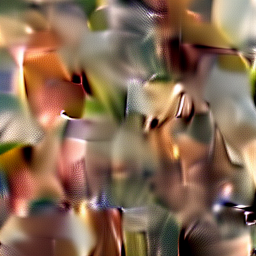

In [7]:
def generate(prompt, num_timesteps=10, latent_dim=[1, 32, 8, 8], latent_seed=42):
    scheduler_generate.set_timesteps(num_timesteps)
    prompt_encoded, prompt_atnmask = encode_prompt(prompt, tokenizer, text_encoder)
    latents = torch.randn(latent_dim, generator = torch.manual_seed(latent_seed)).to(dtype).to(device)

    for t_idx in range(num_timesteps):
        t = scheduler_generate.timesteps[t_idx].unsqueeze(0).to(device)
        with torch.no_grad():
            noise_pred = transformer(latents, encoder_hidden_states=prompt_encoded, timestep=t, encoder_attention_mask=prompt_atnmask, return_dict=False)[0]
        latents = scheduler_generate.step(noise_pred, t, latents, return_dict=False)[0]
    return latent_to_PIL(latents / dcae_scalingf, dcae)

generate("0")

In [8]:
def eval_loss(data_val, num_samples=10, num_timesteps=10, batch_size=24):
    losses = []
    eval_dataloader = iter(DataLoader(data_val, batch_size=batch_size, shuffle=False, collate_fn=collate))

    for i in tqdm(range(num_samples), "eval_loss"):
        label, latent, prompt_encoded, prompt_atnmask = next(eval_dataloader)
        noise = torch.randn_like(latent)
        timestep = scheduler_train.timesteps[[random.randint(0, num_timesteps-1) for _ in range(batch_size)]].to(device)
        latent_noisy = scheduler_train.scale_noise(latent, timestep, noise)
        with torch.no_grad():
            noise_pred = transformer(latent_noisy, encoder_hidden_states = prompt_encoded, encoder_attention_mask = prompt_atnmask, timestep = timestep, return_dict=False)[0]
        loss = F.mse_loss(noise_pred, noise - latent)
        losses.append(loss.item())
    return sum(losses)/len(losses)

eval_loss(ds["train"])

eval_loss: 100%|██████████| 10/10 [00:00<00:00, 13.22it/s]


11.4

In [9]:
def eval_clipscore(seeds=[1,7,42]):
    prompts = [f"handwritten digit {digit}" for digit in range(10)]
    images = [generate(p, latent_seed=seed) for seed in tqdm(seeds, "eval_clipscore") for p in prompts]
    return pil_clipscore(images, prompts*len(seeds))

eval_clipscore()

eval_clipscore: 100%|██████████| 3/3 [00:04<00:00,  1.43s/it]
/usr/local/lib/python3.10/dist-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


22.915660858154297

# Train

In [10]:
log_wandb = True

lr = 5e-4
# bs = 32
bs = 256
epochs = 3
diffuser_timesteps = 10
steps_log, steps_eval = 20, 100

data_train, data_val = ds["train"], ds["test"]

steps_epoch = len(data_train)
steps_total = epochs * (steps_epoch // bs)

dataloader = DataLoader(data_train, batch_size=bs, shuffle=True, generator = torch.manual_seed(seed), collate_fn=collate)
optimizer = torch.optim.AdamW(transformer.parameters(), lr=lr)
scheduler_train.set_timesteps(diffuser_timesteps)

model_size = sum(p.numel() for p in transformer.parameters() if p.requires_grad)
print(f"Number of parameters: {model_size / 1e6:.2f}M")

Number of parameters: 156.41M


In [ ]:
if log_wandb: wandb.init(project="Hana", name=f"Z-{model_size / 1e6:.2f}M_MNIST_LR-{lr}_BS-{bs}_10-TS_LOGNORM-TS").log_code(".", include_fn=lambda path: path.endswith(".py") or path.endswith(".ipynb") or path.endswith(".json"))

t_start, last_step_time = time.time(), time.time()
step, losses = 0, []

for _ in range(epochs):
    for batch in dataloader:        
        transformer.train()
        labels, latents, prompts_encoded, prompts_atnmask = batch
        noise = torch.randn_like(latents)
        timesteps = scheduler_train.timesteps[torch.randint(diffuser_timesteps,(latents.shape[0],))].to(device)
        latents_noisy = scheduler_train.scale_noise(latents, timesteps, noise)
        
        noise_pred = transformer(
            latents_noisy, 
            encoder_hidden_states = prompts_encoded, 
            encoder_attention_mask = prompts_atnmask, 
            timestep = timesteps, 
            return_dict=False
        )[0]
    
        loss = F.mse_loss(noise_pred, noise - latents)
        loss.backward()
        grad_norm = torch.nn.utils.clip_grad_norm_(transformer.parameters(), 1.0)
        optimizer.step()
        optimizer.zero_grad()
        
        losses.append(loss.item())
        step += 1
        sample_count, epoch = step * bs, step * bs / steps_epoch 
        
        if step % steps_log == 0:
            loss_train = sum(losses)/len(losses)
            step_time = (time.time() - last_step_time) / steps_log * 1000
            sample_tp = bs * steps_log / (time.time() - last_step_time)
            print(f"step {step}, epoch: {epoch:.4f}, train loss: {loss_train:.4f}, grad_norm: {grad_norm:.2f}, {step_time:.2f}ms/step, {sample_tp:.2f}samples/sec")
            if log_wandb: wandb.log({"loss_train": loss_train, "grad_norm": grad_norm, "step_time": step_time, "step": step, "epoch": epoch, "sample_tp": sample_tp, "sample_count": sample_count})
            last_step_time, losses = time.time(), []
    
        if step % steps_eval == 0:
            transformer.eval()
            loss_eval, clipscore, images_eval = eval_loss(data_val), eval_clipscore(), make_grid([generate(str(p)) for p in tqdm(range(10), "images_eval")], 2, 5)
            print(f"step {step}, eval loss: {loss_eval:.4f}, clipscore: {clipscore:.2f}")
            if not log_wandb: display(images_eval.resize((300,150)))
            if log_wandb: wandb.log({"loss_eval": loss_eval, "clipscore": clipscore, "images_eval": wandb.Image(images_eval), "step": step, "epoch": epoch, "sample_count": sample_count})


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


step 5, epoch: 0.0213, train loss: 6.6312, grad_norm: 8.88, 865.97ms/step, 295.62samples/sec
step 10, epoch: 0.0427, train loss: 3.0781, grad_norm: 3.70, 841.06ms/step, 304.38samples/sec
step 15, epoch: 0.0640, train loss: 2.7000, grad_norm: 4.41, 878.42ms/step, 291.43samples/sec
step 20, epoch: 0.0853, train loss: 2.2125, grad_norm: 2.23, 833.69ms/step, 307.07samples/sec
step 25, epoch: 0.1067, train loss: 2.0297, grad_norm: 1.52, 831.15ms/step, 308.01samples/sec
step 30, epoch: 0.1280, train loss: 1.9172, grad_norm: 2.02, 828.93ms/step, 308.83samples/sec
step 35, epoch: 0.1493, train loss: 1.7859, grad_norm: 1.43, 880.97ms/step, 290.59samples/sec
step 40, epoch: 0.1707, train loss: 1.7391, grad_norm: 1.80, 839.75ms/step, 304.85samples/sec
step 45, epoch: 0.1920, train loss: 1.6828, grad_norm: 2.08, 890.11ms/step, 287.60samples/sec
step 50, epoch: 0.2133, train loss: 1.6172, grad_norm: 1.80, 842.23ms/step, 303.96samples/sec
step 55, epoch: 0.2347, train loss: 1.5766, grad_norm: 1.70, 

images_eval: 100%|██████████| 10/10 [00:01<00:00,  6.88it/s]


step 100, eval loss: 1.4078, clipscore: 22.92
step 105, epoch: 0.4480, train loss: 1.4125, grad_norm: 1.10, 3532.95ms/step, 72.46samples/sec
step 110, epoch: 0.4693, train loss: 1.3609, grad_norm: 0.73, 825.81ms/step, 310.00samples/sec
step 115, epoch: 0.4907, train loss: 1.3281, grad_norm: 0.86, 886.59ms/step, 288.75samples/sec
step 120, epoch: 0.5120, train loss: 1.3266, grad_norm: 1.27, 836.31ms/step, 306.11samples/sec
step 125, epoch: 0.5333, train loss: 1.3188, grad_norm: 0.96, 836.99ms/step, 305.86samples/sec
step 130, epoch: 0.5547, train loss: 1.3297, grad_norm: 0.89, 837.62ms/step, 305.63samples/sec
step 135, epoch: 0.5760, train loss: 1.2672, grad_norm: 0.71, 881.49ms/step, 290.42samples/sec
step 140, epoch: 0.5973, train loss: 1.2609, grad_norm: 1.35, 840.26ms/step, 304.67samples/sec
step 145, epoch: 0.6187, train loss: 1.2906, grad_norm: 1.03, 834.40ms/step, 306.81samples/sec
step 150, epoch: 0.6400, train loss: 1.2703, grad_norm: 0.79, 879.76ms/step, 290.99samples/sec
step

images_eval: 100%|██████████| 10/10 [00:01<00:00,  7.02it/s]


step 200, eval loss: 1.1617, clipscore: 25.91
step 205, epoch: 0.8747, train loss: 1.2391, grad_norm: 0.66, 3563.35ms/step, 71.84samples/sec
step 210, epoch: 0.8960, train loss: 1.1922, grad_norm: 0.71, 827.48ms/step, 309.37samples/sec
step 215, epoch: 0.9173, train loss: 1.1656, grad_norm: 0.71, 837.02ms/step, 305.85samples/sec
step 220, epoch: 0.9387, train loss: 1.2047, grad_norm: 0.86, 876.91ms/step, 291.93samples/sec
step 225, epoch: 0.9600, train loss: 1.2203, grad_norm: 0.79, 837.43ms/step, 305.70samples/sec
step 230, epoch: 0.9813, train loss: 1.2156, grad_norm: 0.79, 838.96ms/step, 305.14samples/sec
step 235, epoch: 1.0027, train loss: 1.1953, grad_norm: 0.57, 752.38ms/step, 340.25samples/sec
step 240, epoch: 1.0240, train loss: 1.1594, grad_norm: 0.79, 890.68ms/step, 287.42samples/sec
step 245, epoch: 1.0453, train loss: 1.1656, grad_norm: 0.64, 844.76ms/step, 303.05samples/sec
step 250, epoch: 1.0667, train loss: 1.1516, grad_norm: 0.49, 829.08ms/step, 308.77samples/sec
step

images_eval: 100%|██████████| 10/10 [00:01<00:00,  6.67it/s]


step 300, eval loss: 1.1117, clipscore: 27.05
step 305, epoch: 1.3013, train loss: 1.1562, grad_norm: 0.79, 3525.17ms/step, 72.62samples/sec
step 310, epoch: 1.3227, train loss: 1.1453, grad_norm: 0.56, 856.98ms/step, 298.72samples/sec
step 315, epoch: 1.3440, train loss: 1.1172, grad_norm: 0.67, 820.10ms/step, 312.16samples/sec
step 320, epoch: 1.3653, train loss: 1.1484, grad_norm: 0.57, 819.09ms/step, 312.54samples/sec
step 325, epoch: 1.3867, train loss: 1.1406, grad_norm: 0.69, 854.95ms/step, 299.43samples/sec
step 330, epoch: 1.4080, train loss: 1.1516, grad_norm: 0.49, 819.80ms/step, 312.27samples/sec
step 335, epoch: 1.4293, train loss: 1.1156, grad_norm: 1.04, 818.75ms/step, 312.67samples/sec
step 340, epoch: 1.4507, train loss: 1.1203, grad_norm: 1.16, 858.22ms/step, 298.29samples/sec


In [ ]:
transformer.push_to_hub(f"g-ronimo/hana-small_alpha10")

In [ ]:
# !runpodctl remove pod $RUNPOD_POD_ID